In [4]:
# -*- coding: utf_8 -*-
import os
import cv2
import pickle
import tensorflow as tf
import math
import numpy as np
import keras
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K
from keras.engine.input_layer import Input
from keras.models import Model

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers import BatchNormalization, Lambda, AveragePooling2D
from keras.layers import GlobalAveragePooling2D, Activation, concatenate
from keras.regularizers import l2
from keras.utils import multi_gpu_model
%config InlineBackend.figure_formats = {'png', 'retina'}
mpl.rc('font', family='AppleGothic')
mpl.rc('axes', unicode_minus=False)

In [4]:
backbone = keras.applications.ResNet50(input_shape=(256,256,3), include_top=False)

/Users/MAC/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [28]:
def gcd_model(input_shape, num_classes=None):
    """
    backbone model : ResNet50
    
    descriptor dim : 1024 (512 * 2) 
    """
    model = keras.applications.ResNet50(input_shape=input_shape, include_top=False)

    gd1 = GlobalAveragePooling2D()(model.layers[-1].output)
    gd2 = GlobalGeMPooling2D()(model.layers[-1].output)
 
    des1 = Dense(512, activation='elu', kernel_regularizer='l2')(gd1)
    des2 = Dense(512, activation='elu', kernel_regularizer='l2')(gd2)
    
    aux = Dense(num_classes, activation='softmax')(des1)
    
    con = concatenate([des1, des2])
    cos = CosineTheta(num_classes, 512*2)(con)

    model_new = Model(inputs=model.input, outputs=[aux, cos])

    return model_new

In [25]:
from keras.engine.base_layer import InputSpec, Layer
from keras.utils import conv_utils
from keras.legacy import interfaces

class _GlobalPooling2D(Layer):
    """Abstract class for different global pooling 2D layers.
    """

    @interfaces.legacy_global_pooling_support
    def __init__(self, data_format=None, **kwargs):
        super(_GlobalPooling2D, self).__init__(**kwargs)
        self.data_format = K.normalize_data_format(data_format)
        self.input_spec = InputSpec(ndim=4)
        self.pk = K.variable(value=2., dtype='float')

    def compute_output_shape(self, input_shape):
        if self.data_format == 'channels_last':
            return (input_shape[0], input_shape[3])
        else:
            return (input_shape[0], input_shape[1])

    def call(self, inputs):
        raise NotImplementedError

    def get_config(self):
        config = {'data_format': self.data_format}
        base_config = super(_GlobalPooling2D, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class GlobalGeMPooling2D(_GlobalPooling2D):
    """Global average pooling operation for spatial data.
    # Arguments
        data_format: A string,
            one of `channels_last` (default) or `channels_first`.
            The ordering of the dimensions in the inputs.
            `channels_last` corresponds to inputs with shape
            `(batch, height, width, channels)` while `channels_first`
            corresponds to inputs with shape
            `(batch, channels, height, width)`.
            It defaults to the `image_data_format` value found in your
            Keras config file at `~/.keras/keras.json`.
            If you never set it, then it will be "channels_last".
    # Input shape
        - If `data_format='channels_last'`:
            4D tensor with shape:
            `(batch_size, rows, cols, channels)`
        - If `data_format='channels_first'`:
            4D tensor with shape:
            `(batch_size, channels, rows, cols)`
    # Output shape
        2D tensor with shape:
        `(batch_size, channels)`
    """

    def call(self, inputs):
        if self.data_format == 'channels_last':
            return K.pow(K.mean(K.pow(inputs, self.pk), axis=[1, 2]), 1/self.pk)
        else:
            return K.pow(K.mean(K.pow(inputs, self.pk), axis=[2, 3]), 1/self.pk)


In [ ]:
keras.callbacks.TensorBoard(log_dir="./logs/", update_freq='batch')

# CSV file EDA

In [4]:
df = pd.read_csv("./data/train/train.csv")

In [5]:
df.tail()

,Part_snap,Part_tag,Snapshot,recommend_item,tags,게시일,관련 브랜드,스타일,이름(나이),직업,촬영일,촬영지역,특집분류
595,595_0_part.png 595_1_part.png 595_2_part.png,블레이저/블랙/아우터/검정색&와이드팬츠/화이트/하의/흰색&부츠/블랙/신발/검정색,595_snap.png,595_0_reco.png 595_1_reco.png 595_2_reco.png 5...,여자 브라탑 블레이저 와이드팬츠 부츠,2019-03-13,687 / 3 / 1,스트리트/힙합,조연화 (연령미상),학생,2019-03-13,부산/경남,NaN
596,596_0_part.png 596_1_part.png,스웨트셔츠/블랙/상의/검정색&팬츠/블랙/하의/검정색,596_snap.png,596_0_reco.png 596_1_reco.png 596_2_reco.png 5...,남자 티셔츠 스웨트팬츠 스니커즈,2019-03-13,594 / 1 / 2,스트리트/힙합,고영준 (21),모델,2019-03-13,동대문,NaN
597,597_0_part.png 597_1_part.png,베스트/블랙/아우터/검정색&스니커즈/블랙/신발/검정색,597_snap.png,597_0_reco.png 597_1_reco.png 597_2_reco.png 5...,여자 버킷햇 백팩 재킷 베스트 카고팬츠 스니커즈,2019-03-13,570 / 0 / 1,스트리트/힙합,최예진 (23),패션업,2019-03-13,홍대/신촌,NaN
598,598_0_part.png 598_1_part.png 598_2_part.png,트러커재킷/블랙/아우터/검정색&카고팬츠/블랙/하의/검정색&스니커즈/옐로/신발/노란색,598_snap.png,598_0_reco.png 598_1_reco.png 598_2_reco.png 5...,여자 헤어밴드 트러커재킷 백팩 셔츠 카고팬츠 스니커즈,2019-03-13,531 / 0 / 1,스트리트/힙합,심희주 (28),전문직/프리랜서,2019-03-13,홍대/신촌,NaN
599,599_0_part.png,야상/카키/아우터/녹색,599_snap.png,599_0_reco.png 599_1_reco.png 599_2_reco.png 5...,남자 안경 티셔츠 야상 조거팬츠 스니커즈,2019-03-13,473 / 0 / 1,스트리트/힙합,김남혁 (24),전문직/프리랜서,2019-03-13,홍대/신촌,NaN


In [138]:
sns.palettes.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

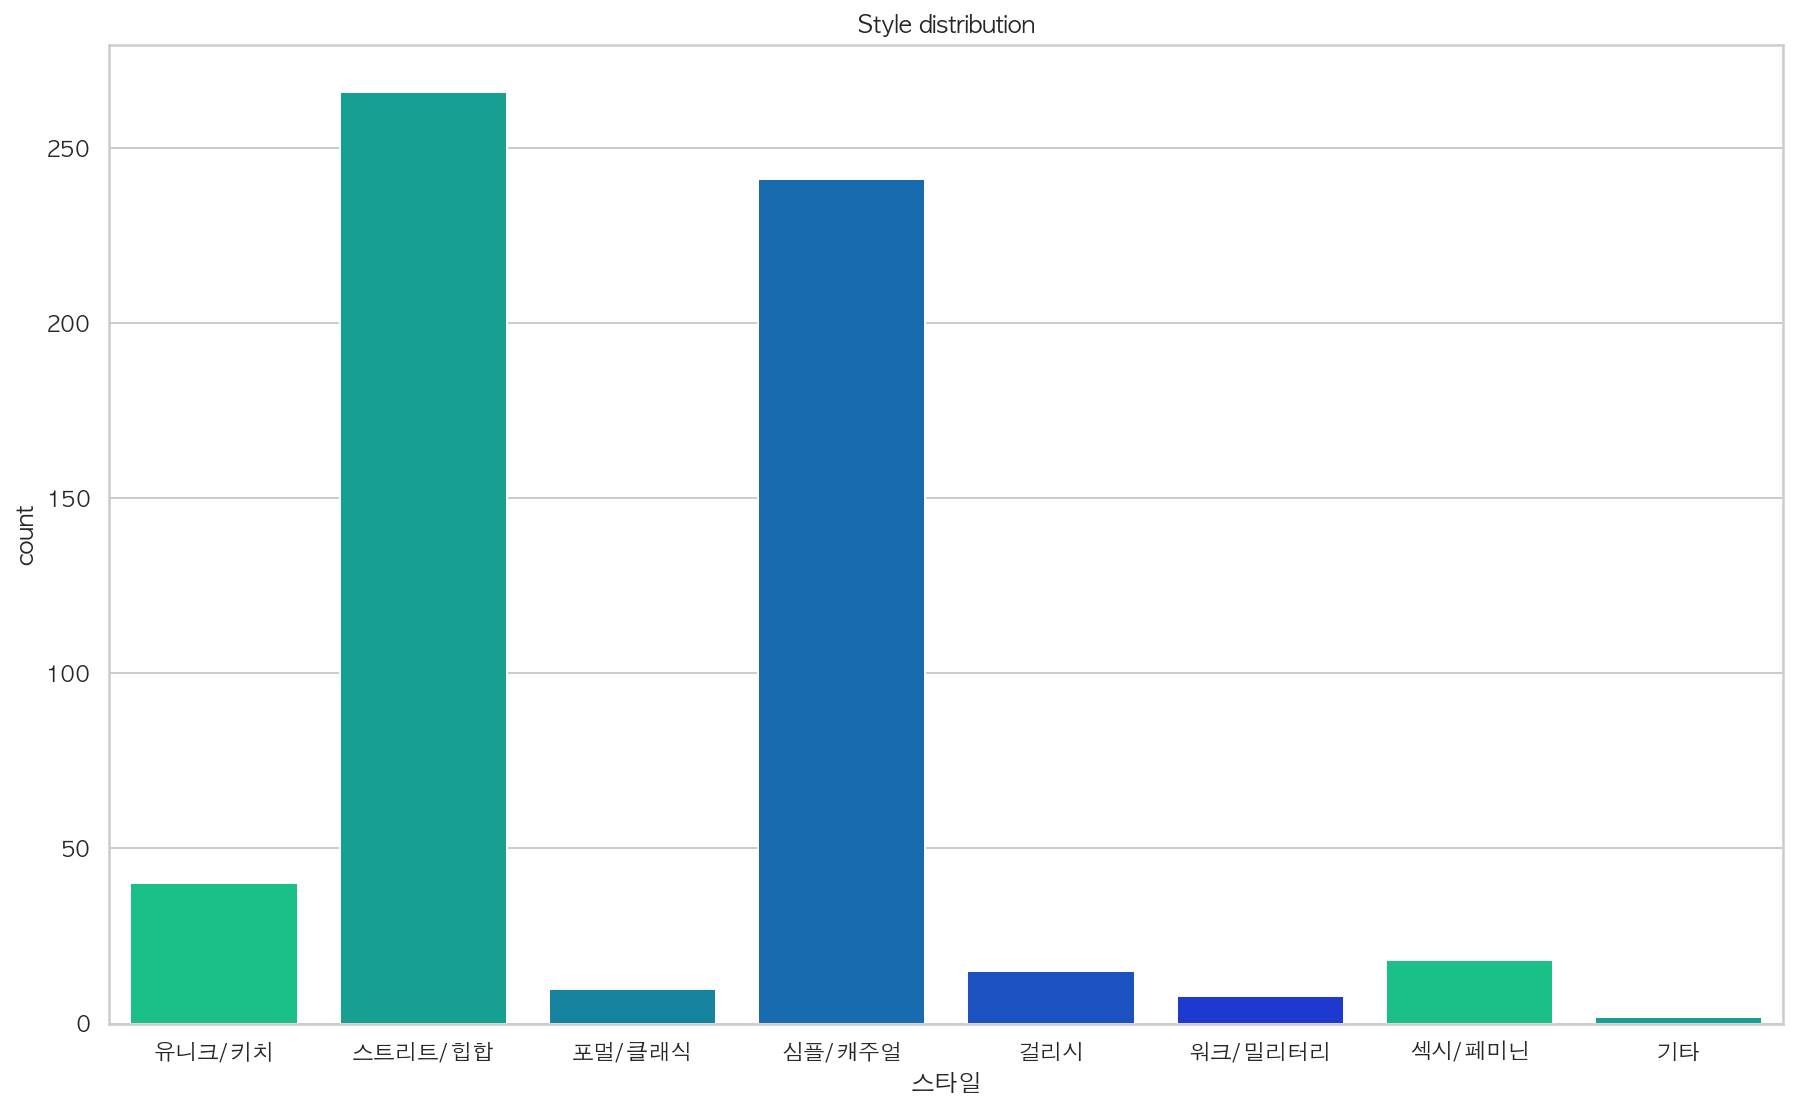

In [158]:
plt.figure(figsize=(15,9))
sns.countplot(df[r"스타일"], palette=sns.palettes.color_palette("winter_r"))
plt.title("Style distribution")
plt.show()

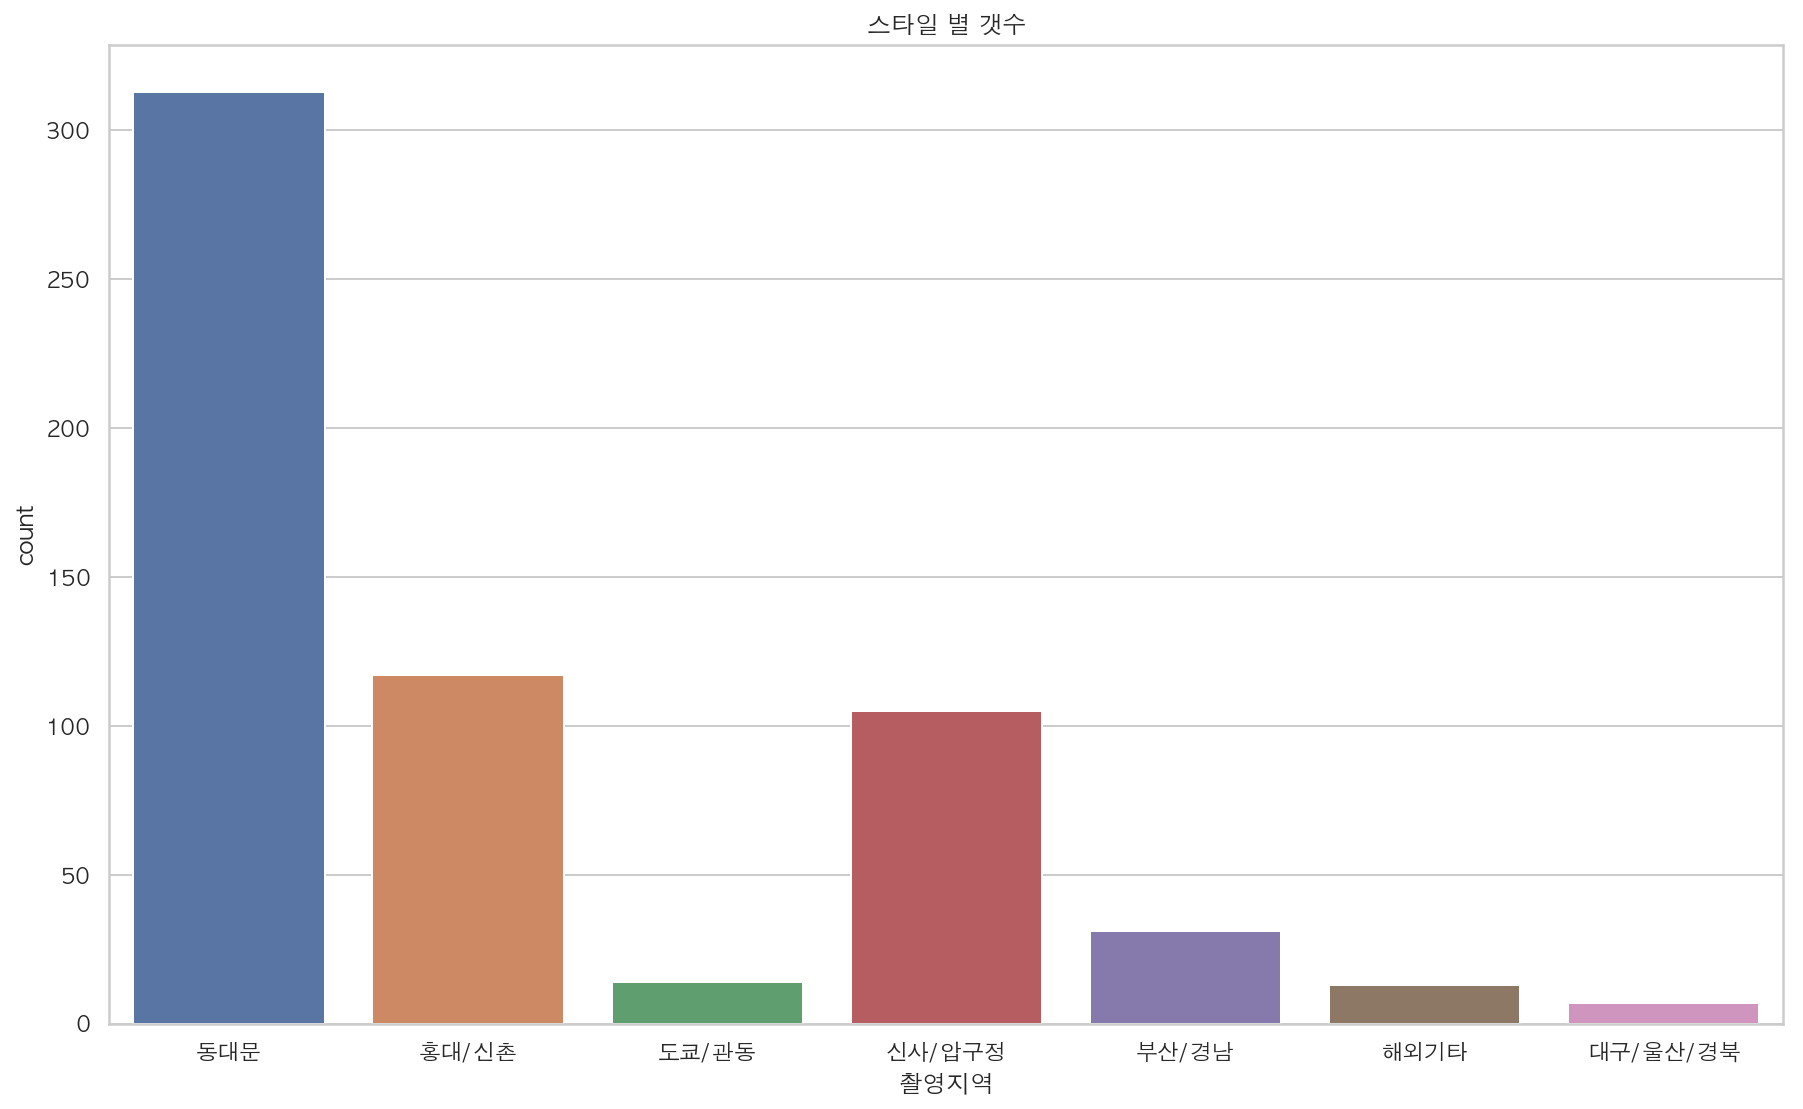

In [13]:
plt.figure(figsize=(15,9))
sns.countplot(df[r"촬영지역"])
plt.title("스타일 별 갯수")
plt.show()

In [19]:
tag_count = {}
for tag in df.tags:
    tag_set = str(tag).split()
    for t in tag_set: 
        if t in tag_count.keys():
            tag_count[t] += 1 
        else:
            tag_count[t] = 1 
            


In [51]:
len(tag_count.keys())
top50 = sorted(tag_count.items(), key=lambda x : x[1], reverse=True)[:50]

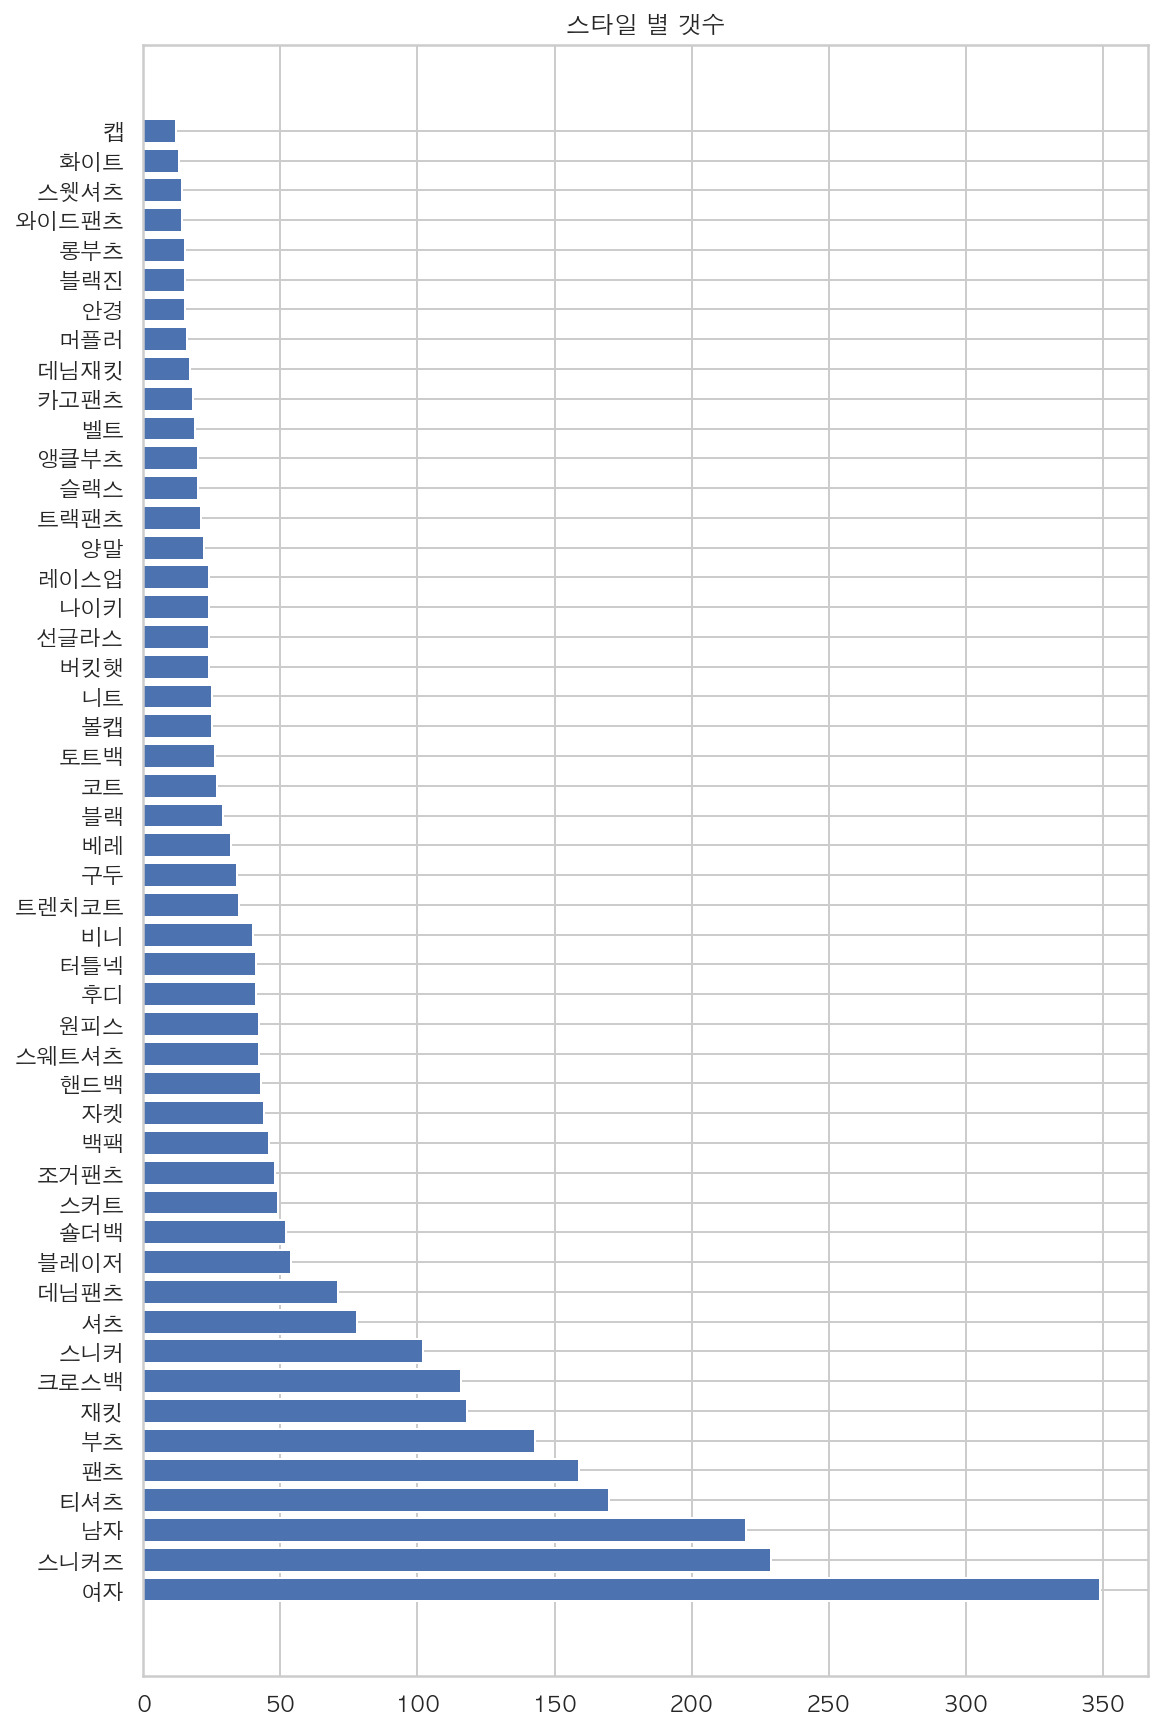

In [52]:
plt.figure(figsize=(9,15))
pos = np.arange(50)
plt.barh(pos, [val[1] for val in top50])
plt.yticks(pos, [val[0] for val in top50])
plt.title("스타일 별 갯수")
plt.show()

In [55]:
tag_count[r'여자'] / sum(tag_count.values())

0.09086175475136683

In [56]:
part_tag_count = {}
for tag in df.Part_tag:
    tag_sets = str(tag).split("&")
    for tag_set in tag_sets:
        tags = str(tag_set).split("/")
        for t in tags:

            if t in part_tag_count.keys():
                part_tag_count[t] += 1 
            else:
                part_tag_count[t] = 1 


In [57]:
len(part_tag_count.keys())

400

In [59]:

top50 = sorted(part_tag_count.items(), key=lambda x : x[1], reverse=True)

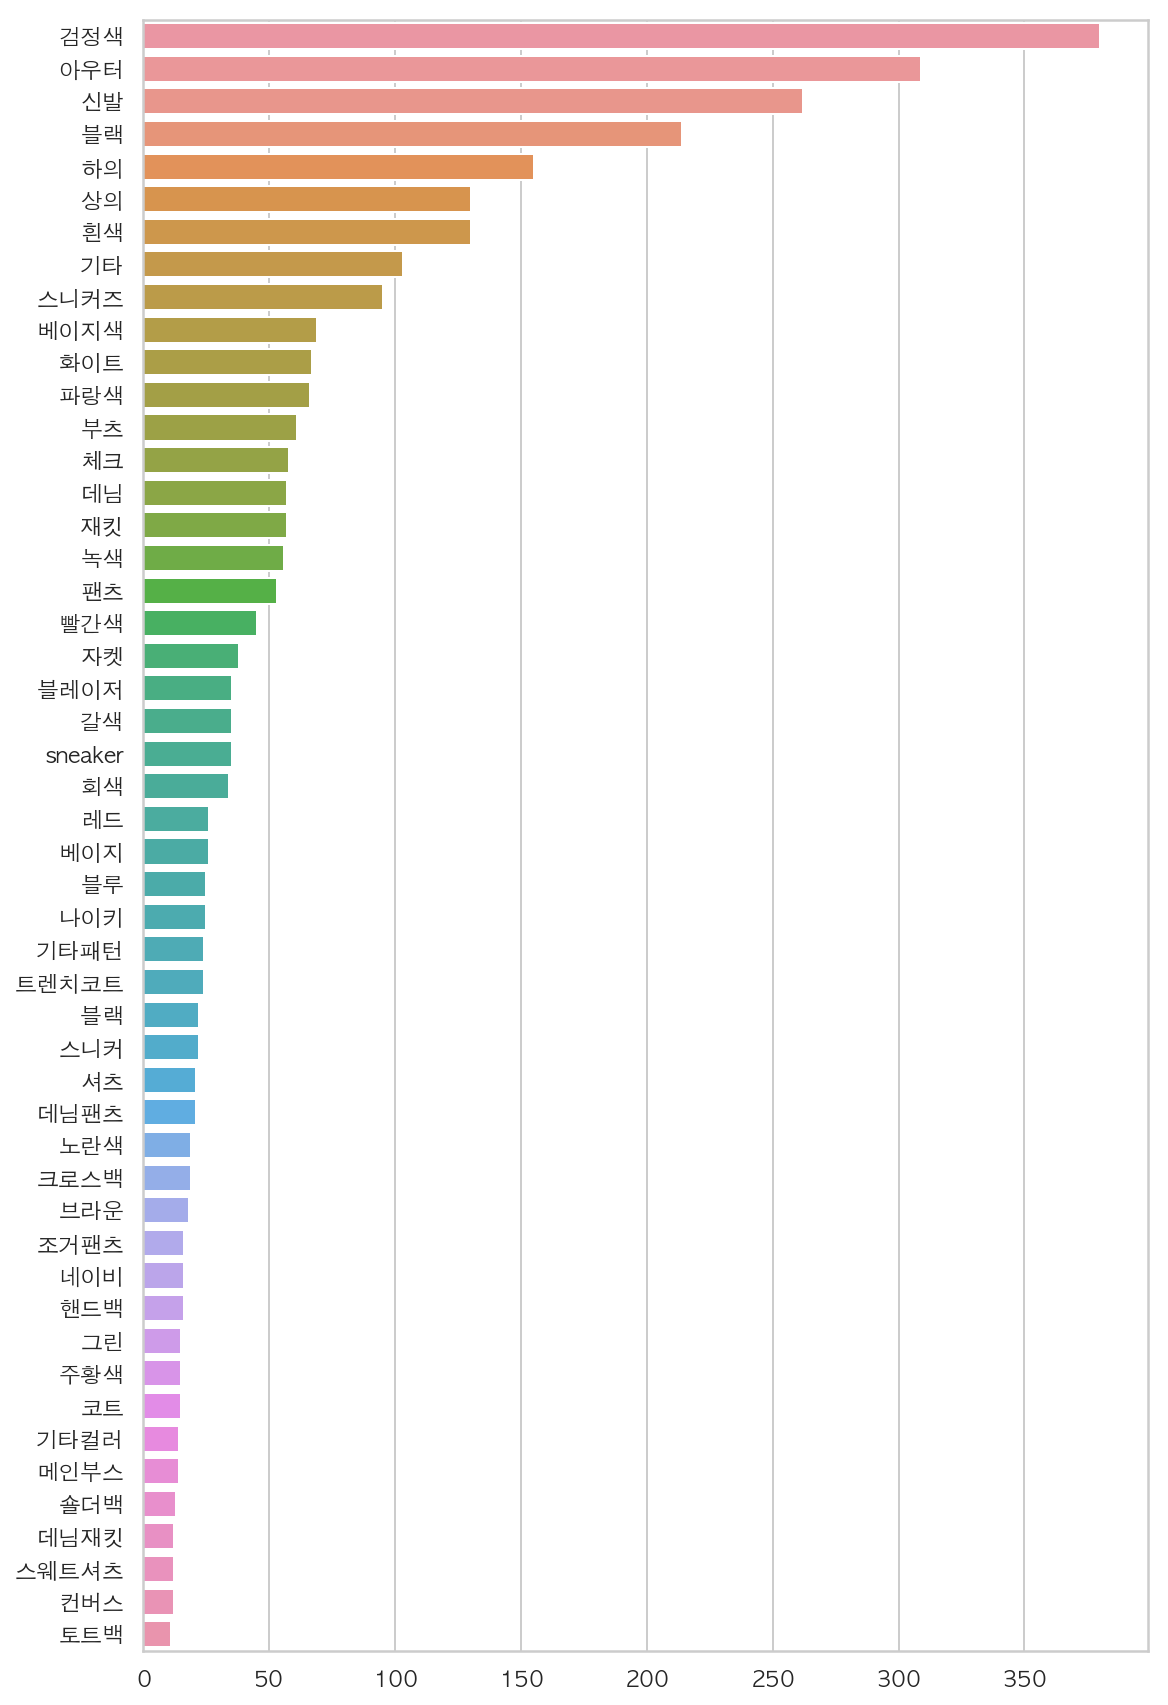

In [62]:
top50[:50]

plt.figure(figsize=(9, 15))
sns.barplot([x[1] for x in top50[:50]], [x[0] for x in top50[:50]])

In [67]:
sum([t[1] for t in top50[:80]]) / sum(part_tag_count.values())

0.8557919621749409

In [72]:
views = df[r"관련 브랜드"].apply(lambda x : int(x.split("/")[0].strip().replace(",", "")))

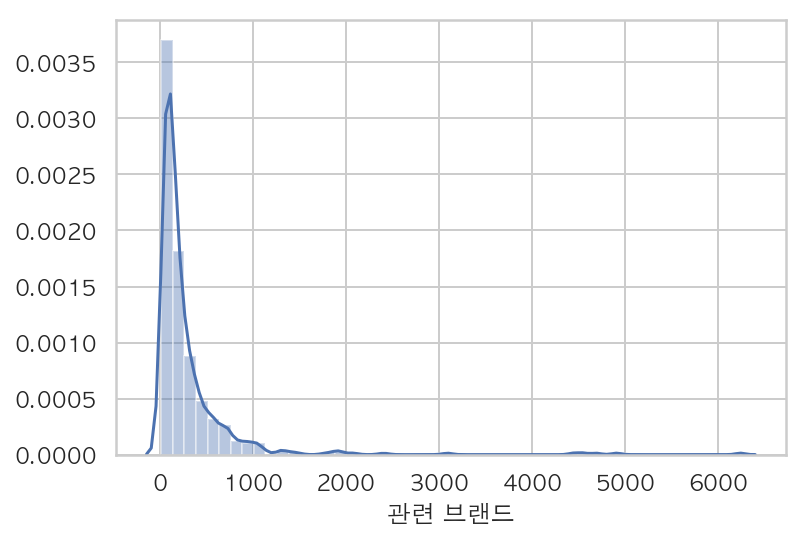

In [74]:
sns.distplot(views)

In [75]:
views.describe()

count     600.000000
mean      302.995000
std       538.390802
min        13.000000
25%        79.750000
50%       156.000000
75%       321.750000
max      6236.000000
Name: 관련 브랜드, dtype: float64

In [90]:
idx_top = views.sort_values(ascending=False).index[:100]
idx_bottom = views.sort_values(ascending=False).index[100:]

### 조회수를 많이 받은 게시물(상위 100) 들의 태그 변화

In [117]:
df.tail()

,Part_snap,Part_tag,Snapshot,recommend_item,tags,게시일,관련 브랜드,스타일,이름(나이),직업,촬영일,촬영지역,특집분류
595,595_0_part.png 595_1_part.png 595_2_part.png,블레이저/블랙/아우터/검정색&와이드팬츠/화이트/하의/흰색&부츠/블랙/신발/검정색,595_snap.png,595_0_reco.png 595_1_reco.png 595_2_reco.png 5...,여자 브라탑 블레이저 와이드팬츠 부츠,2019-03-13,687 / 3 / 1,스트리트/힙합,조연화 (연령미상),학생,2019-03-13,부산/경남,NaN
596,596_0_part.png 596_1_part.png,스웨트셔츠/블랙/상의/검정색&팬츠/블랙/하의/검정색,596_snap.png,596_0_reco.png 596_1_reco.png 596_2_reco.png 5...,남자 티셔츠 스웨트팬츠 스니커즈,2019-03-13,594 / 1 / 2,스트리트/힙합,고영준 (21),모델,2019-03-13,동대문,NaN
597,597_0_part.png 597_1_part.png,베스트/블랙/아우터/검정색&스니커즈/블랙/신발/검정색,597_snap.png,597_0_reco.png 597_1_reco.png 597_2_reco.png 5...,여자 버킷햇 백팩 재킷 베스트 카고팬츠 스니커즈,2019-03-13,570 / 0 / 1,스트리트/힙합,최예진 (23),패션업,2019-03-13,홍대/신촌,NaN
598,598_0_part.png 598_1_part.png 598_2_part.png,트러커재킷/블랙/아우터/검정색&카고팬츠/블랙/하의/검정색&스니커즈/옐로/신발/노란색,598_snap.png,598_0_reco.png 598_1_reco.png 598_2_reco.png 5...,여자 헤어밴드 트러커재킷 백팩 셔츠 카고팬츠 스니커즈,2019-03-13,531 / 0 / 1,스트리트/힙합,심희주 (28),전문직/프리랜서,2019-03-13,홍대/신촌,NaN
599,599_0_part.png,야상/카키/아우터/녹색,599_snap.png,599_0_reco.png 599_1_reco.png 599_2_reco.png 5...,남자 안경 티셔츠 야상 조거팬츠 스니커즈,2019-03-13,473 / 0 / 1,스트리트/힙합,김남혁 (24),전문직/프리랜서,2019-03-13,홍대/신촌,NaN


In [104]:
tag_count_top = {}

for tags in df.iloc[idx_top].Part_tag:
    tags_sets = tags.split("&")
    for tag_set in tags_sets:
        tags_ = tag_set.split("/")
        for t in tags_:
            if t in tag_count_top.keys():
                tag_count_top[t] += 1 
            else :
                tag_count_top[t] = 1 

In [105]:
tag_count_bottom = {}

for tags in df.iloc[idx_bottom].Part_tag:
    tags_sets = tags.split("&")
    for tag_set in tags_sets:
        tags_ = tag_set.split("/")
        for t in tags_:
            if t in tag_count_bottom.keys():
                tag_count_bottom[t] += 1 
            else :
                tag_count_bottom[t] = 1 

##### 상위권들의 태그 

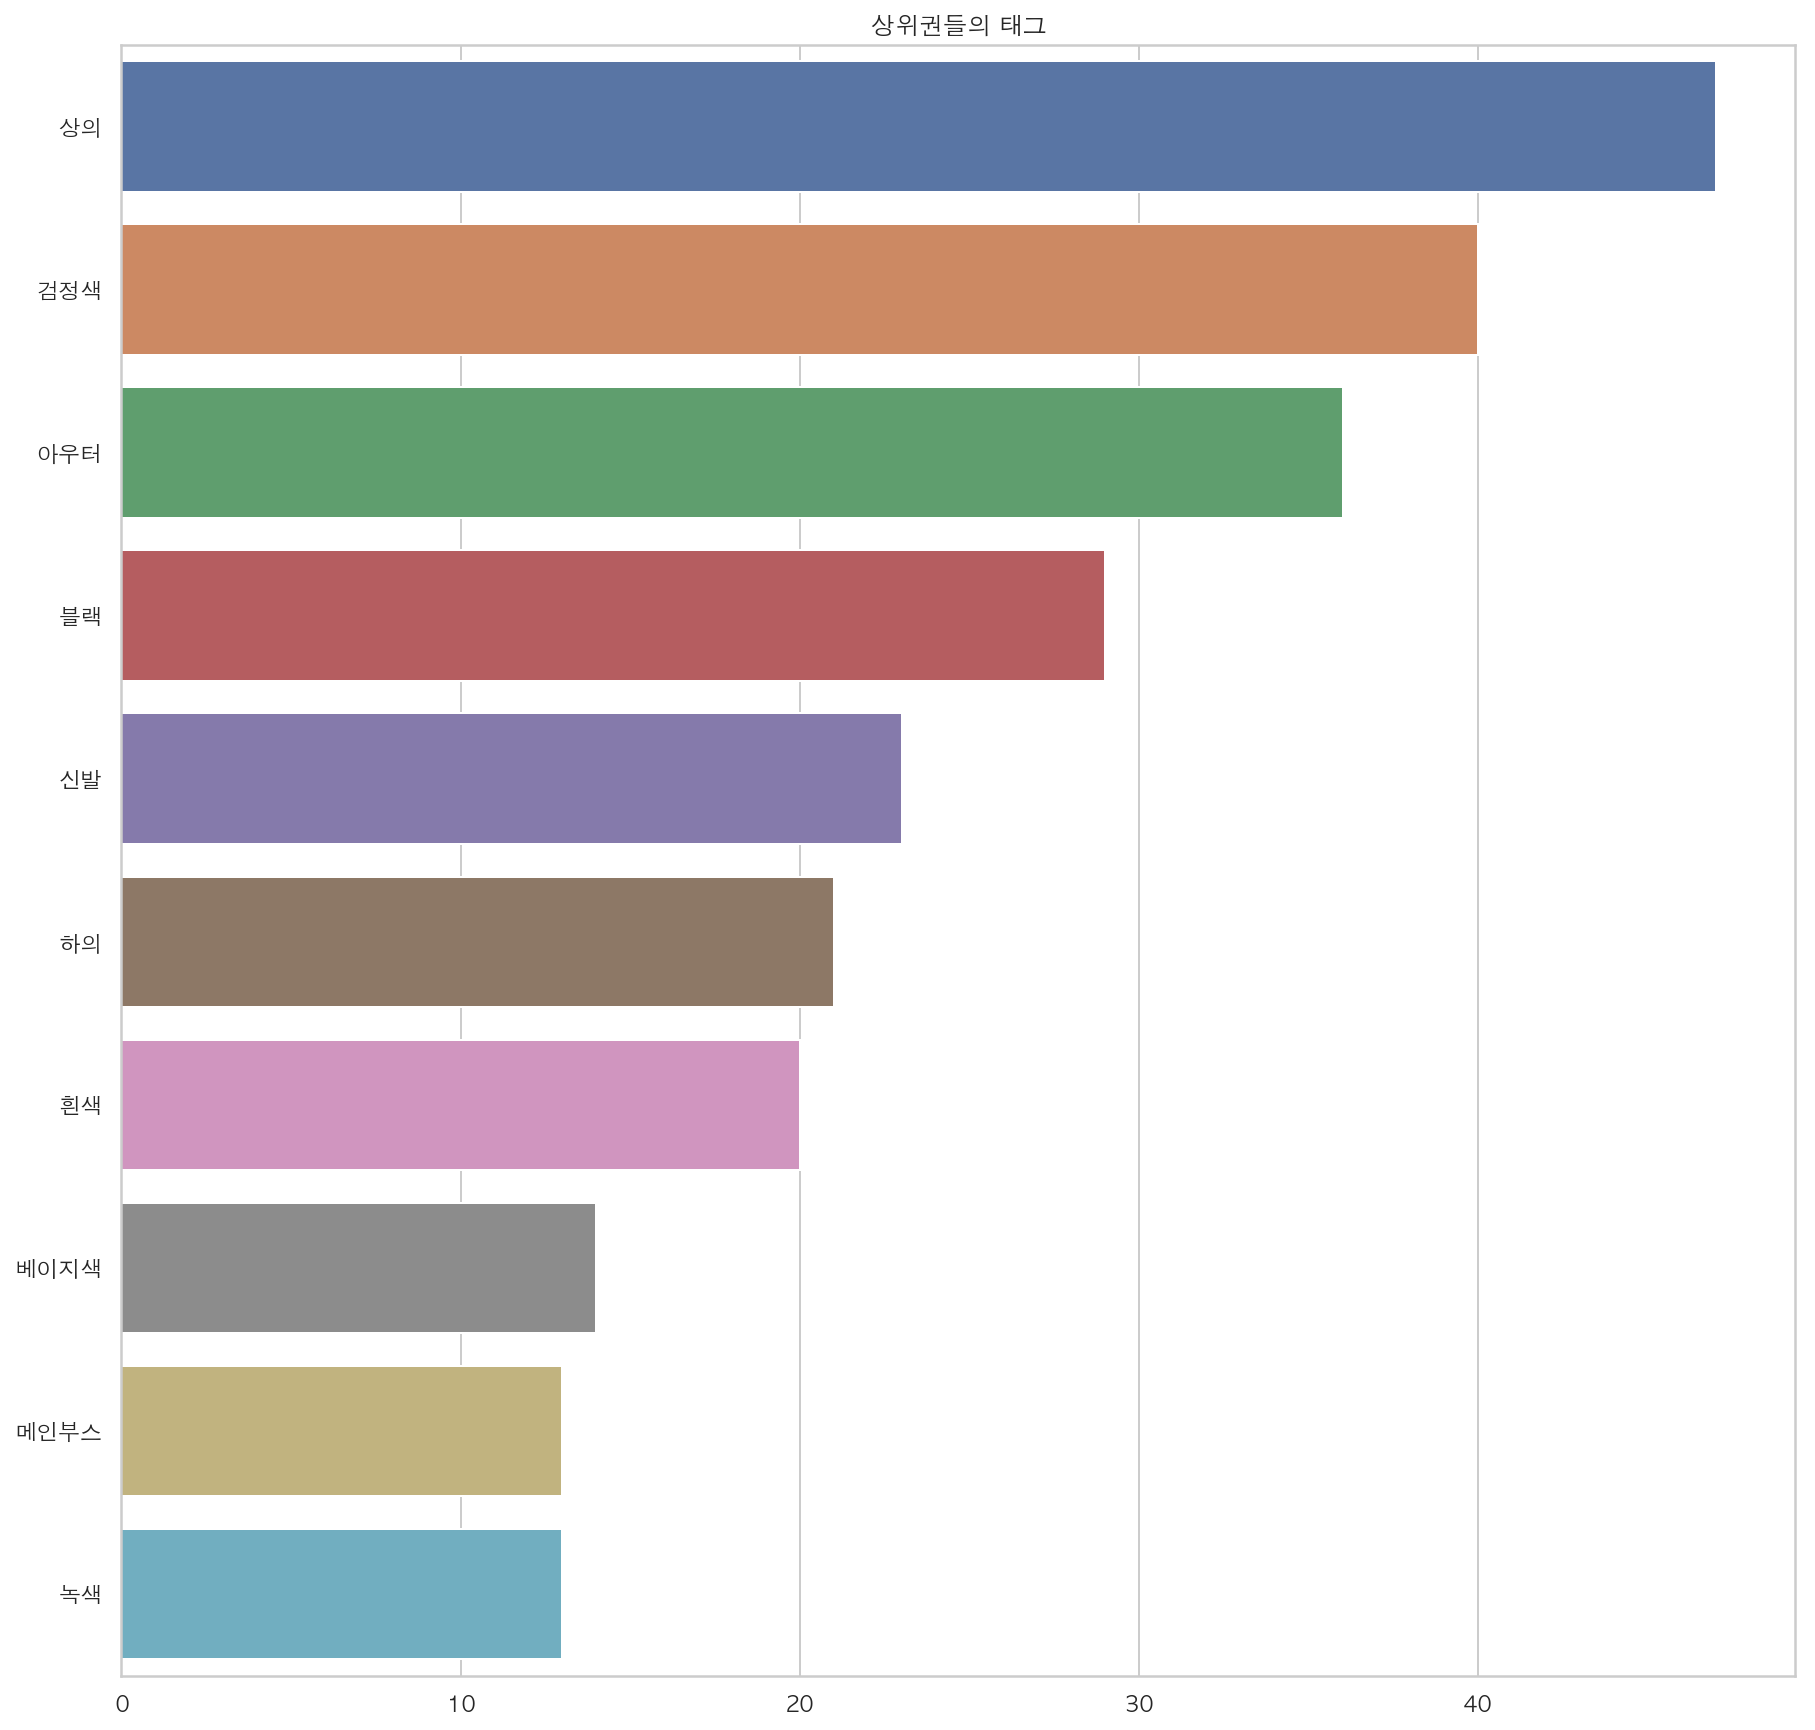

In [112]:
tag_count_top_s = sorted(tag_count_top.items(), key=lambda x : x[1], reverse=True)
plt.figure(figsize=(15, 15))
sns.barplot([t[1] for t in tag_count_top_s[:10]], [t[0] for t in tag_count_top_s[:10]])
plt.title("상위권들의 태그")
plt.show()

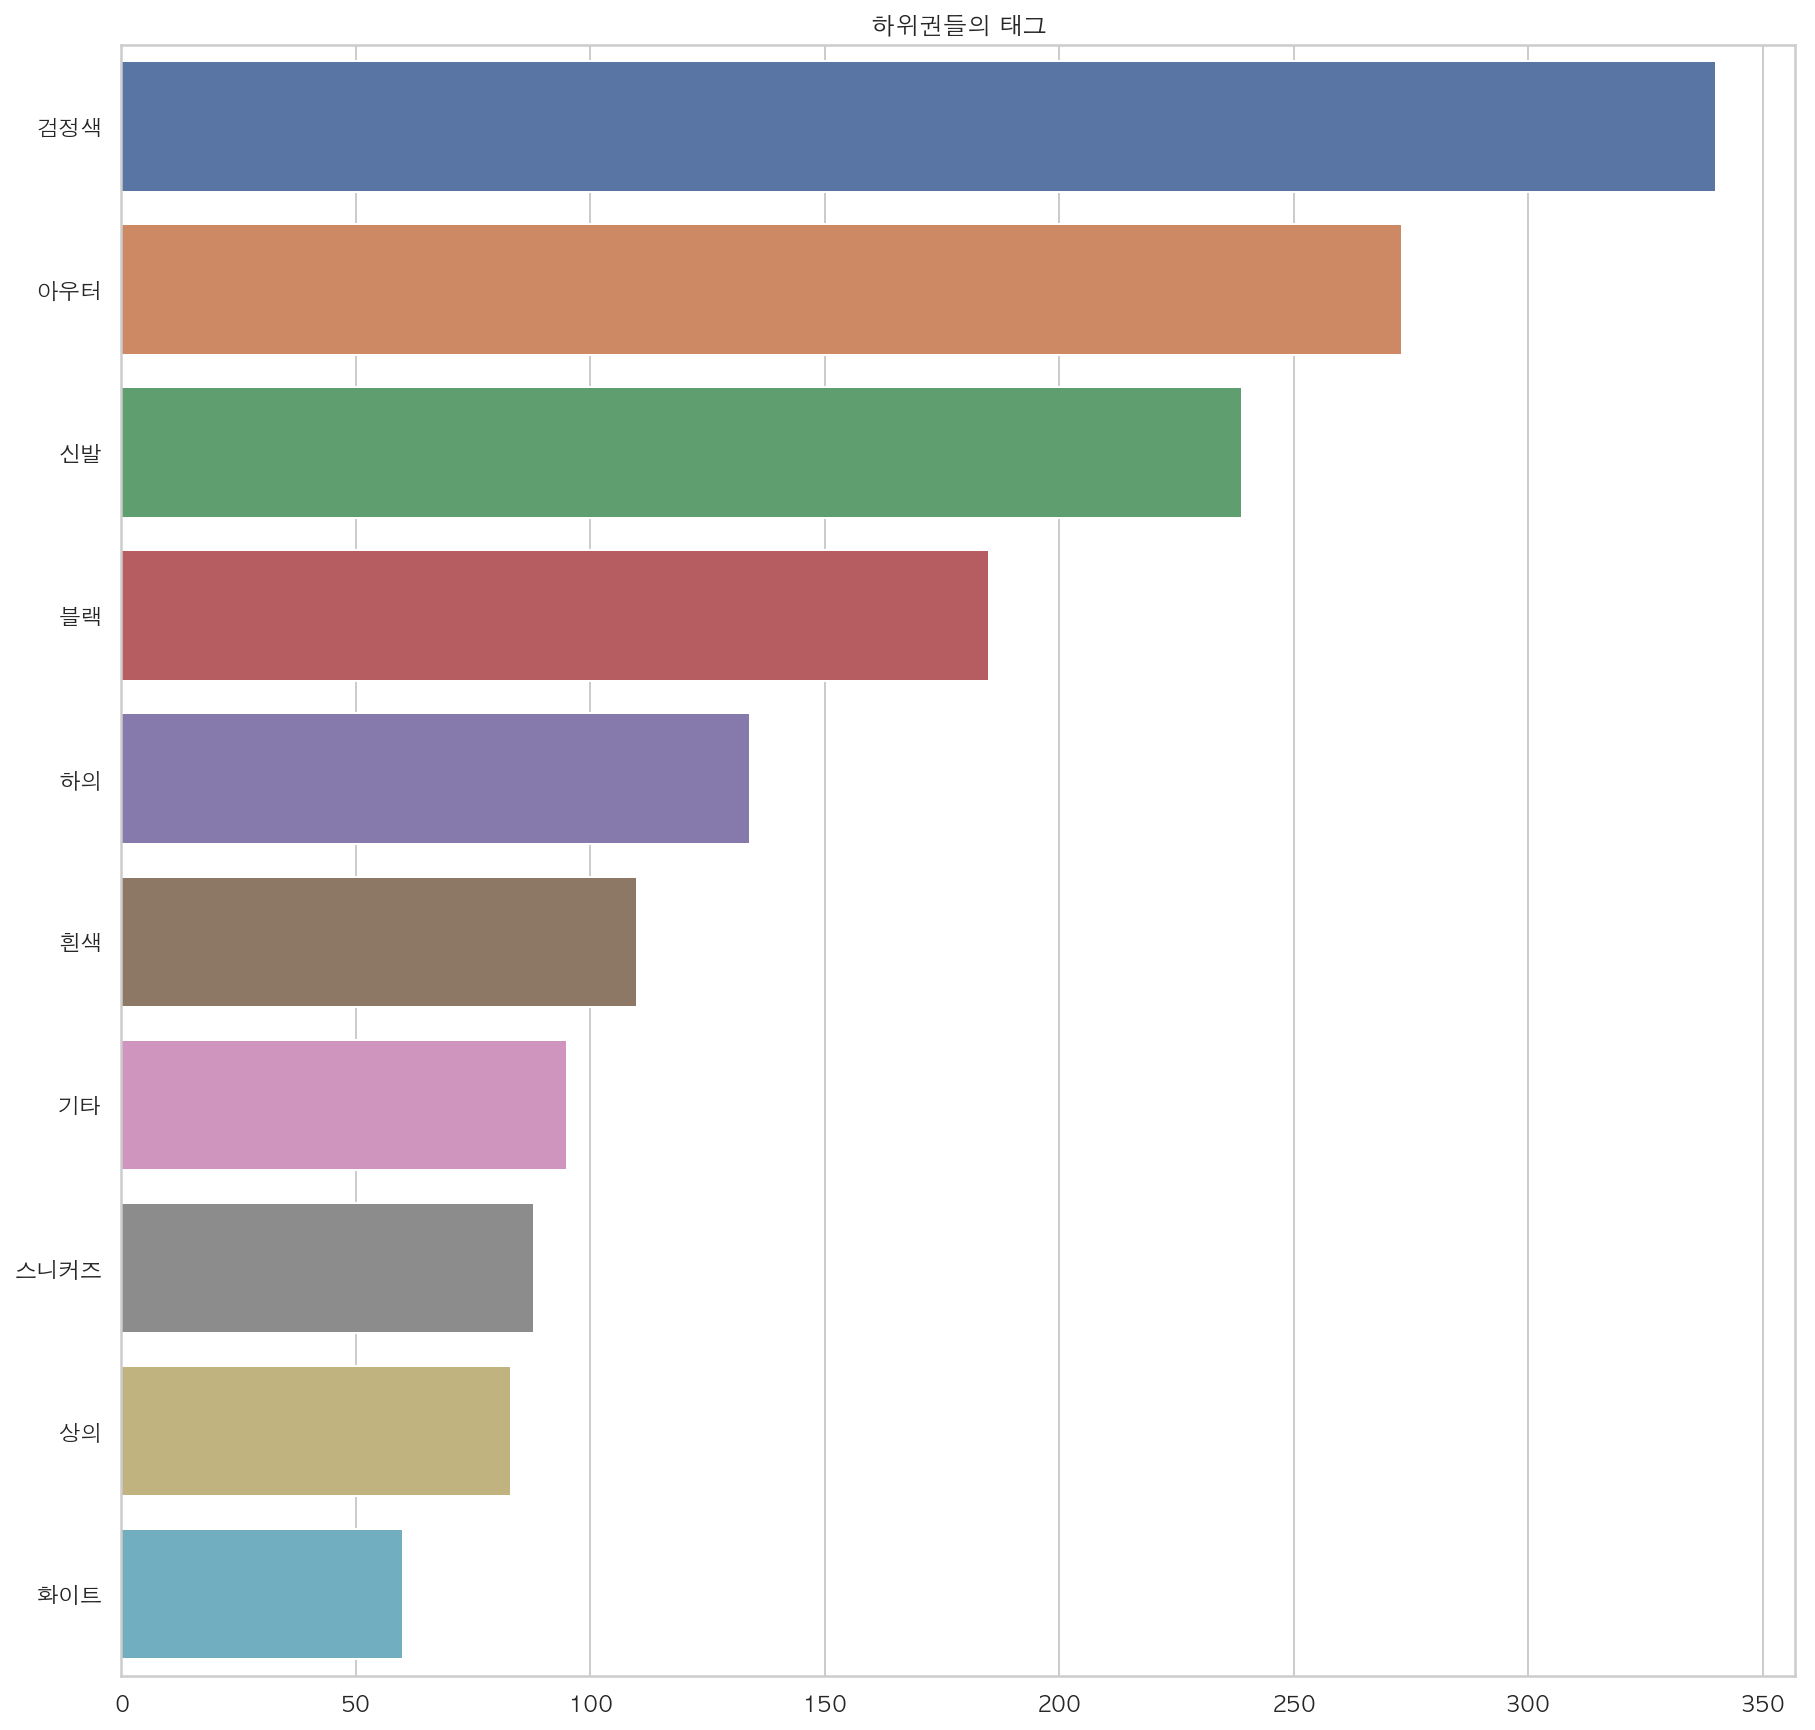

In [113]:
tag_count_bottom_s = sorted(tag_count_bottom.items(), key=lambda x : x[1], reverse=True)
plt.figure(figsize=(15, 15))
sns.barplot([t[1] for t in tag_count_bottom_s[:10]], [t[0] for t in tag_count_bottom_s[:10]])
plt.title("하위권들의 태그")
plt.show()

In [111]:
tag_count_top_s

[('상의', 47),
 ('검정색', 40),
 ('아우터', 36),
 ('블랙', 29),
 ('신발', 23),
 ('하의', 21),
 ('흰색', 20),
 ('베이지색', 14),
 ('메인부스', 13),
 ('녹색', 13),
 ('체크', 11),
 ('파랑색', 11),
 ('기타', 8),
 ('스니커즈', 7),
 ('화이트', 7),
 ('블레이저', 7),
 ('갈색', 6),
 ('팬츠', 5),
 ('데님', 5),
 ('2019 SIGNATURE T-SHIRTS', 5),
 ('빨간색', 5),
 ('부츠', 5),
 ('회색', 4),
 ('핸드백', 4),
 ('자켓', 4),
 ('블루', 4),
 ('재킷', 4),
 ('크로스백', 3),
 ('나이키', 3),
 ('기타패턴', 3),
 ('블레이져', 3),
 ('5252 바이 오아이오아이', 3),
 ('가디건', 3),
 ('주황색', 3),
 ('보라색', 3),
 ('스웨트셔츠', 3),
 ('2019 시그니처 점퍼', 3),
 ('애니멀', 2),
 ('반스', 2),
 ('sneaker', 2),
 ('데님팬츠', 2),
 ('Cherry T-shirt', 2),
 ('Strawberry T-shirt', 2),
 ('은색', 2),
 ('테이핑 롱 슬리브 티셔츠', 2),
 ('5252바이오아이오아이', 2),
 ('후디', 2),
 ('구두', 2),
 ('트러커', 2),
 ('후드집업', 2),
 ('베이지', 2),
 ('MNBTH Fleece Hood T-shirt', 2),
 (' 셋업', 2),
 ('브라운', 2),
 ('스니커', 2),
 ('트랙팬츠', 1),
 ('워크자켓', 1),
 ('워크팬츠', 1),
 ('포스', 1),
 ('아노락', 1),
 ('코튼팬츠', 1),
 ('cotton', 1),
 ('skirt', 1),
 ('슬립온', 1),
 ('릴랙스 오버사이즈 크루넥', 1),
 ('아디다스', 1),
 ('LOGO T

In [110]:
tag_count_bottom_s

[('검정색', 340),
 ('아우터', 273),
 ('신발', 239),
 ('블랙', 185),
 ('하의', 134),
 ('흰색', 110),
 ('기타', 95),
 ('스니커즈', 88),
 ('상의', 83),
 ('화이트', 60),
 ('부츠', 56),
 ('파랑색', 55),
 ('베이지색', 55),
 ('재킷', 53),
 ('데님', 52),
 ('팬츠', 48),
 ('체크', 47),
 ('녹색', 43),
 ('빨간색', 40),
 ('자켓', 34),
 ('sneaker', 33),
 ('회색', 30),
 ('갈색', 29),
 ('블레이저', 28),
 ('레드', 26),
 ('베이지', 24),
 ('트렌치코트', 23),
 ('나이키', 22),
 (' 블랙', 22),
 ('블루', 21),
 ('기타패턴', 21),
 ('스니커', 20),
 ('셔츠', 20),
 ('데님팬츠', 19),
 ('노란색', 18),
 ('브라운', 16),
 ('크로스백', 16),
 ('그린', 15),
 ('조거팬츠', 15),
 ('코트', 15),
 ('네이비', 15),
 ('기타컬러', 13),
 ('숄더백', 13),
 ('컨버스', 12),
 ('주황색', 12),
 ('핸드백', 12),
 ('데님재킷', 11),
 ('원피스', 10),
 ('토트백', 10),
 ('스웨트셔츠', 9),
 ('구두', 9),
 ('SNEAKER', 9),
 ('숏패딩', 9),
 ('분홍색', 9),
 ('스프라이트', 9),
 ('그레이', 8),
 ('카모', 8),
 ('트랙자켓', 8),
 ('레이스업', 8),
 (' 화이트', 8),
 ('후디', 8),
 ('항공점퍼', 7),
 ('카고팬츠', 7),
 ('카키', 7),
 ('닥터마틴', 7),
 ('니트', 7),
 (' 재킷', 7),
 ('레더', 7),
 ('레더재킷', 7),
 ('휠라', 6),
 ('애니멀', 6),
 ('롱부츠', 6),
 ('데님자

In [114]:
df.tail()

,Part_snap,Part_tag,Snapshot,recommend_item,tags,게시일,관련 브랜드,스타일,이름(나이),직업,촬영일,촬영지역,특집분류
595,595_0_part.png 595_1_part.png 595_2_part.png,블레이저/블랙/아우터/검정색&와이드팬츠/화이트/하의/흰색&부츠/블랙/신발/검정색,595_snap.png,595_0_reco.png 595_1_reco.png 595_2_reco.png 5...,여자 브라탑 블레이저 와이드팬츠 부츠,2019-03-13,687 / 3 / 1,스트리트/힙합,조연화 (연령미상),학생,2019-03-13,부산/경남,NaN
596,596_0_part.png 596_1_part.png,스웨트셔츠/블랙/상의/검정색&팬츠/블랙/하의/검정색,596_snap.png,596_0_reco.png 596_1_reco.png 596_2_reco.png 5...,남자 티셔츠 스웨트팬츠 스니커즈,2019-03-13,594 / 1 / 2,스트리트/힙합,고영준 (21),모델,2019-03-13,동대문,NaN
597,597_0_part.png 597_1_part.png,베스트/블랙/아우터/검정색&스니커즈/블랙/신발/검정색,597_snap.png,597_0_reco.png 597_1_reco.png 597_2_reco.png 5...,여자 버킷햇 백팩 재킷 베스트 카고팬츠 스니커즈,2019-03-13,570 / 0 / 1,스트리트/힙합,최예진 (23),패션업,2019-03-13,홍대/신촌,NaN
598,598_0_part.png 598_1_part.png 598_2_part.png,트러커재킷/블랙/아우터/검정색&카고팬츠/블랙/하의/검정색&스니커즈/옐로/신발/노란색,598_snap.png,598_0_reco.png 598_1_reco.png 598_2_reco.png 5...,여자 헤어밴드 트러커재킷 백팩 셔츠 카고팬츠 스니커즈,2019-03-13,531 / 0 / 1,스트리트/힙합,심희주 (28),전문직/프리랜서,2019-03-13,홍대/신촌,NaN
599,599_0_part.png,야상/카키/아우터/녹색,599_snap.png,599_0_reco.png 599_1_reco.png 599_2_reco.png 5...,남자 안경 티셔츠 야상 조거팬츠 스니커즈,2019-03-13,473 / 0 / 1,스트리트/힙합,김남혁 (24),전문직/프리랜서,2019-03-13,홍대/신촌,NaN


In [126]:
tags_top = {}

for tag in df.iloc[idx_top].tags:
    for t in str(tag).split():
        if t in tags_top.keys():
            tags_top[t] += 1 
            
        else :
            tags_top[t] = 1 
            
tags_bottom = {}

for tag in df.iloc[idx_bottom].tags:
    for t in str(tag).split():
        if t in tags_bottom.keys():
            tags_bottom[t] += 1 
            
        else :
            tags_bottom[t] = 1 

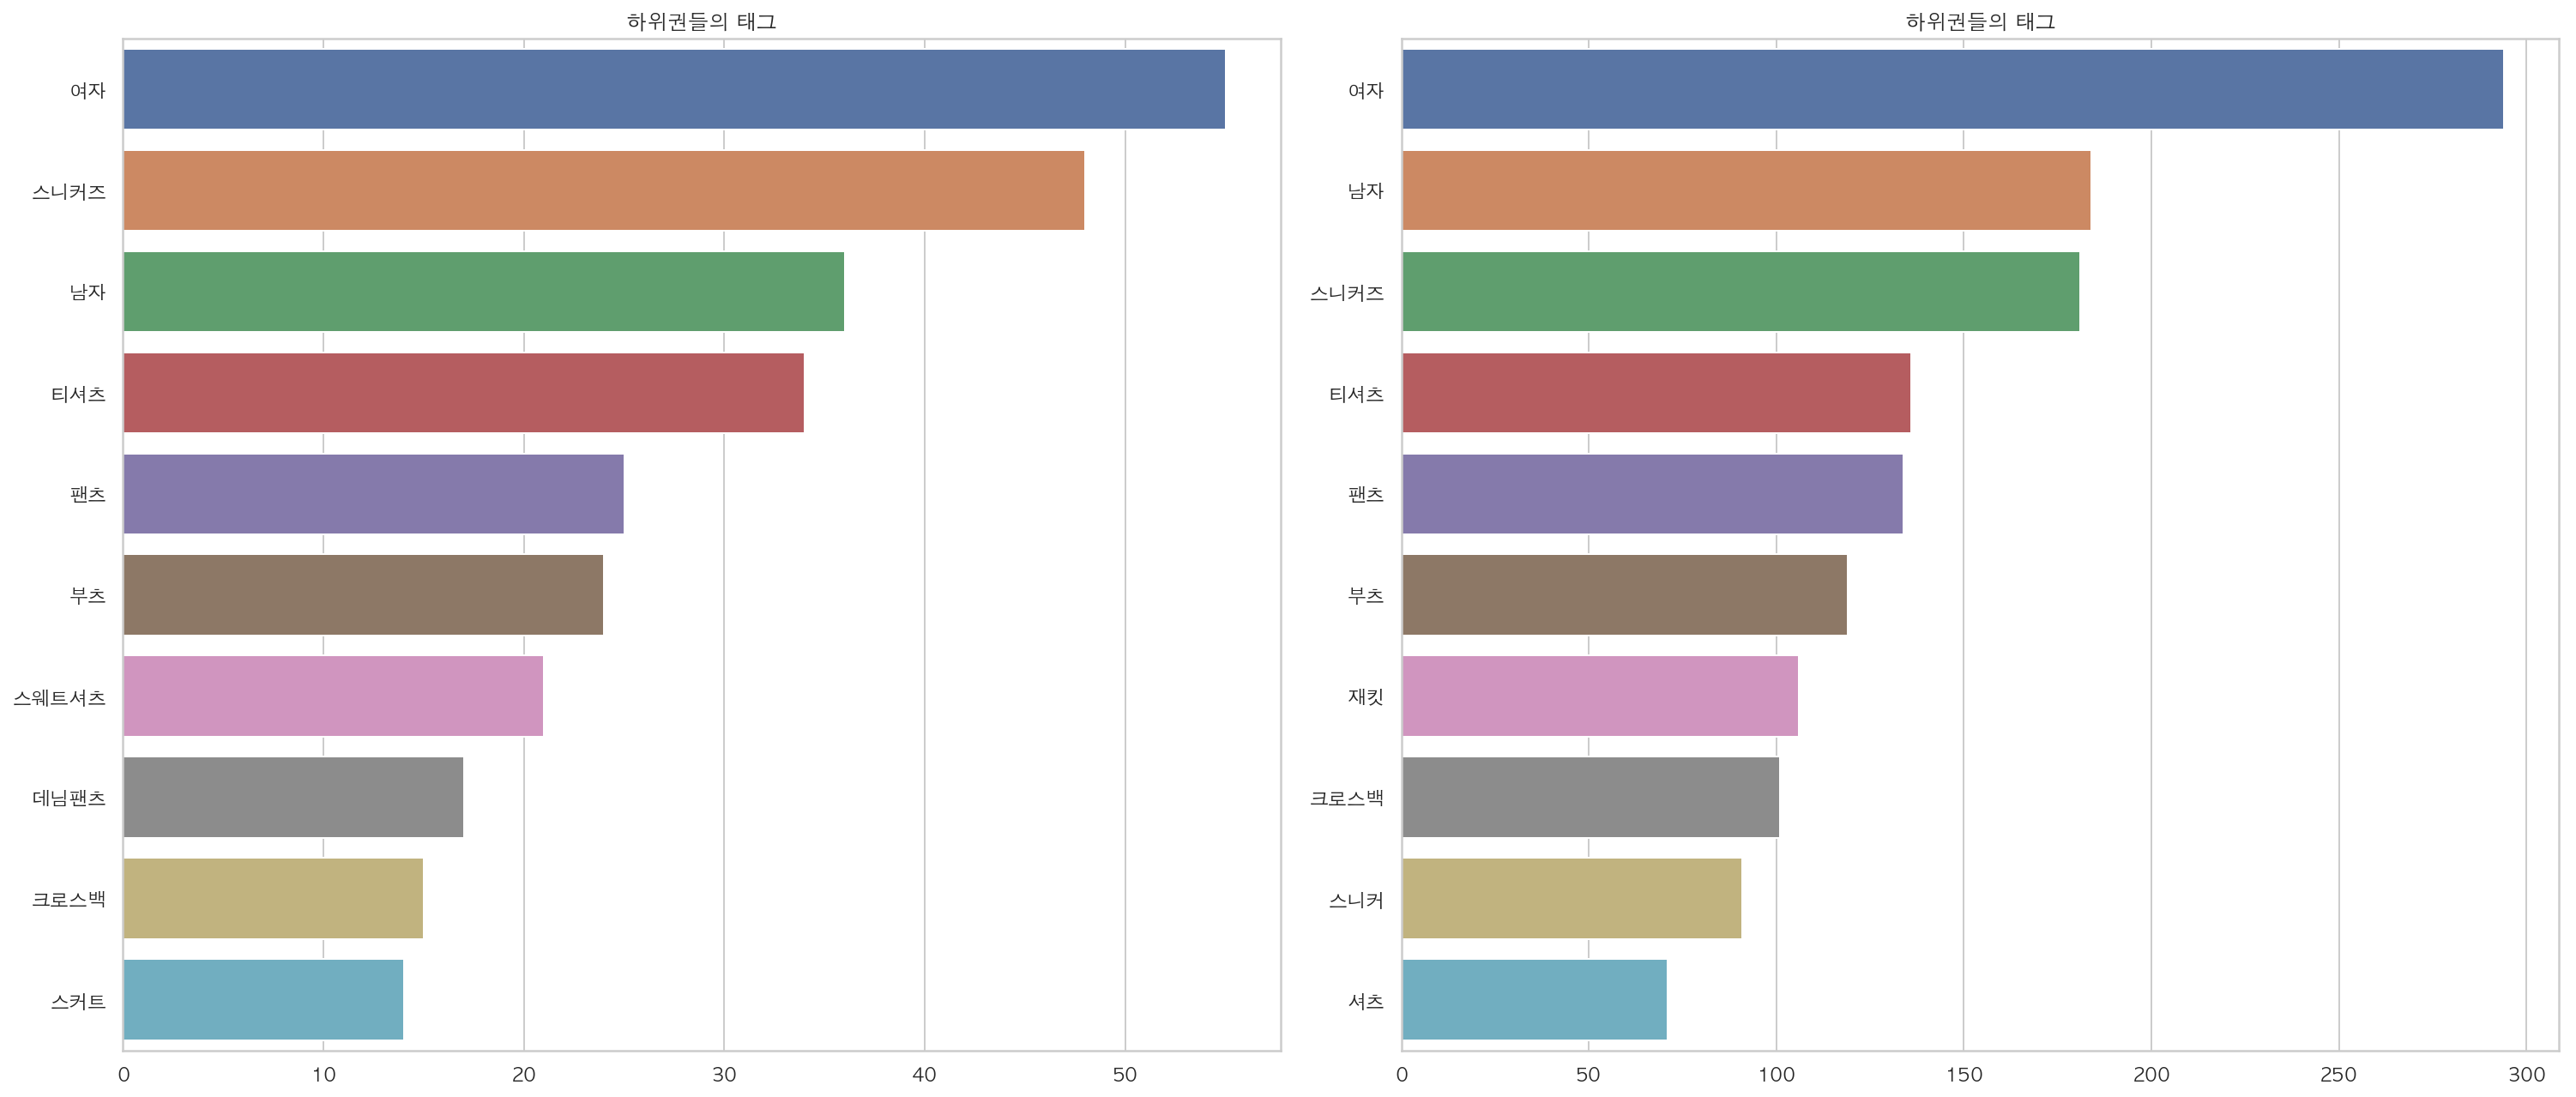

In [133]:
# tags_top

plt.figure(figsize=(21, 9))
plt.subplot(121)
tags_top_s = sorted(tags_top.items(), key=lambda x : x[1], reverse=True)
sns.barplot([t[1] for t in tags_top_s[:10]], [t[0] for t in tags_top_s[:10]])
plt.title("하위권들의 태그")

plt.subplot(122)
# tags_top

tags_bottom_s = sorted(tags_bottom.items(), key=lambda x : x[1], reverse=True)
sns.barplot([t[1] for t in tags_bottom_s[:10]], [t[0] for t in tags_bottom_s[:10]])
plt.title("하위권들의 태그")

plt.tight_layout()
plt.show()


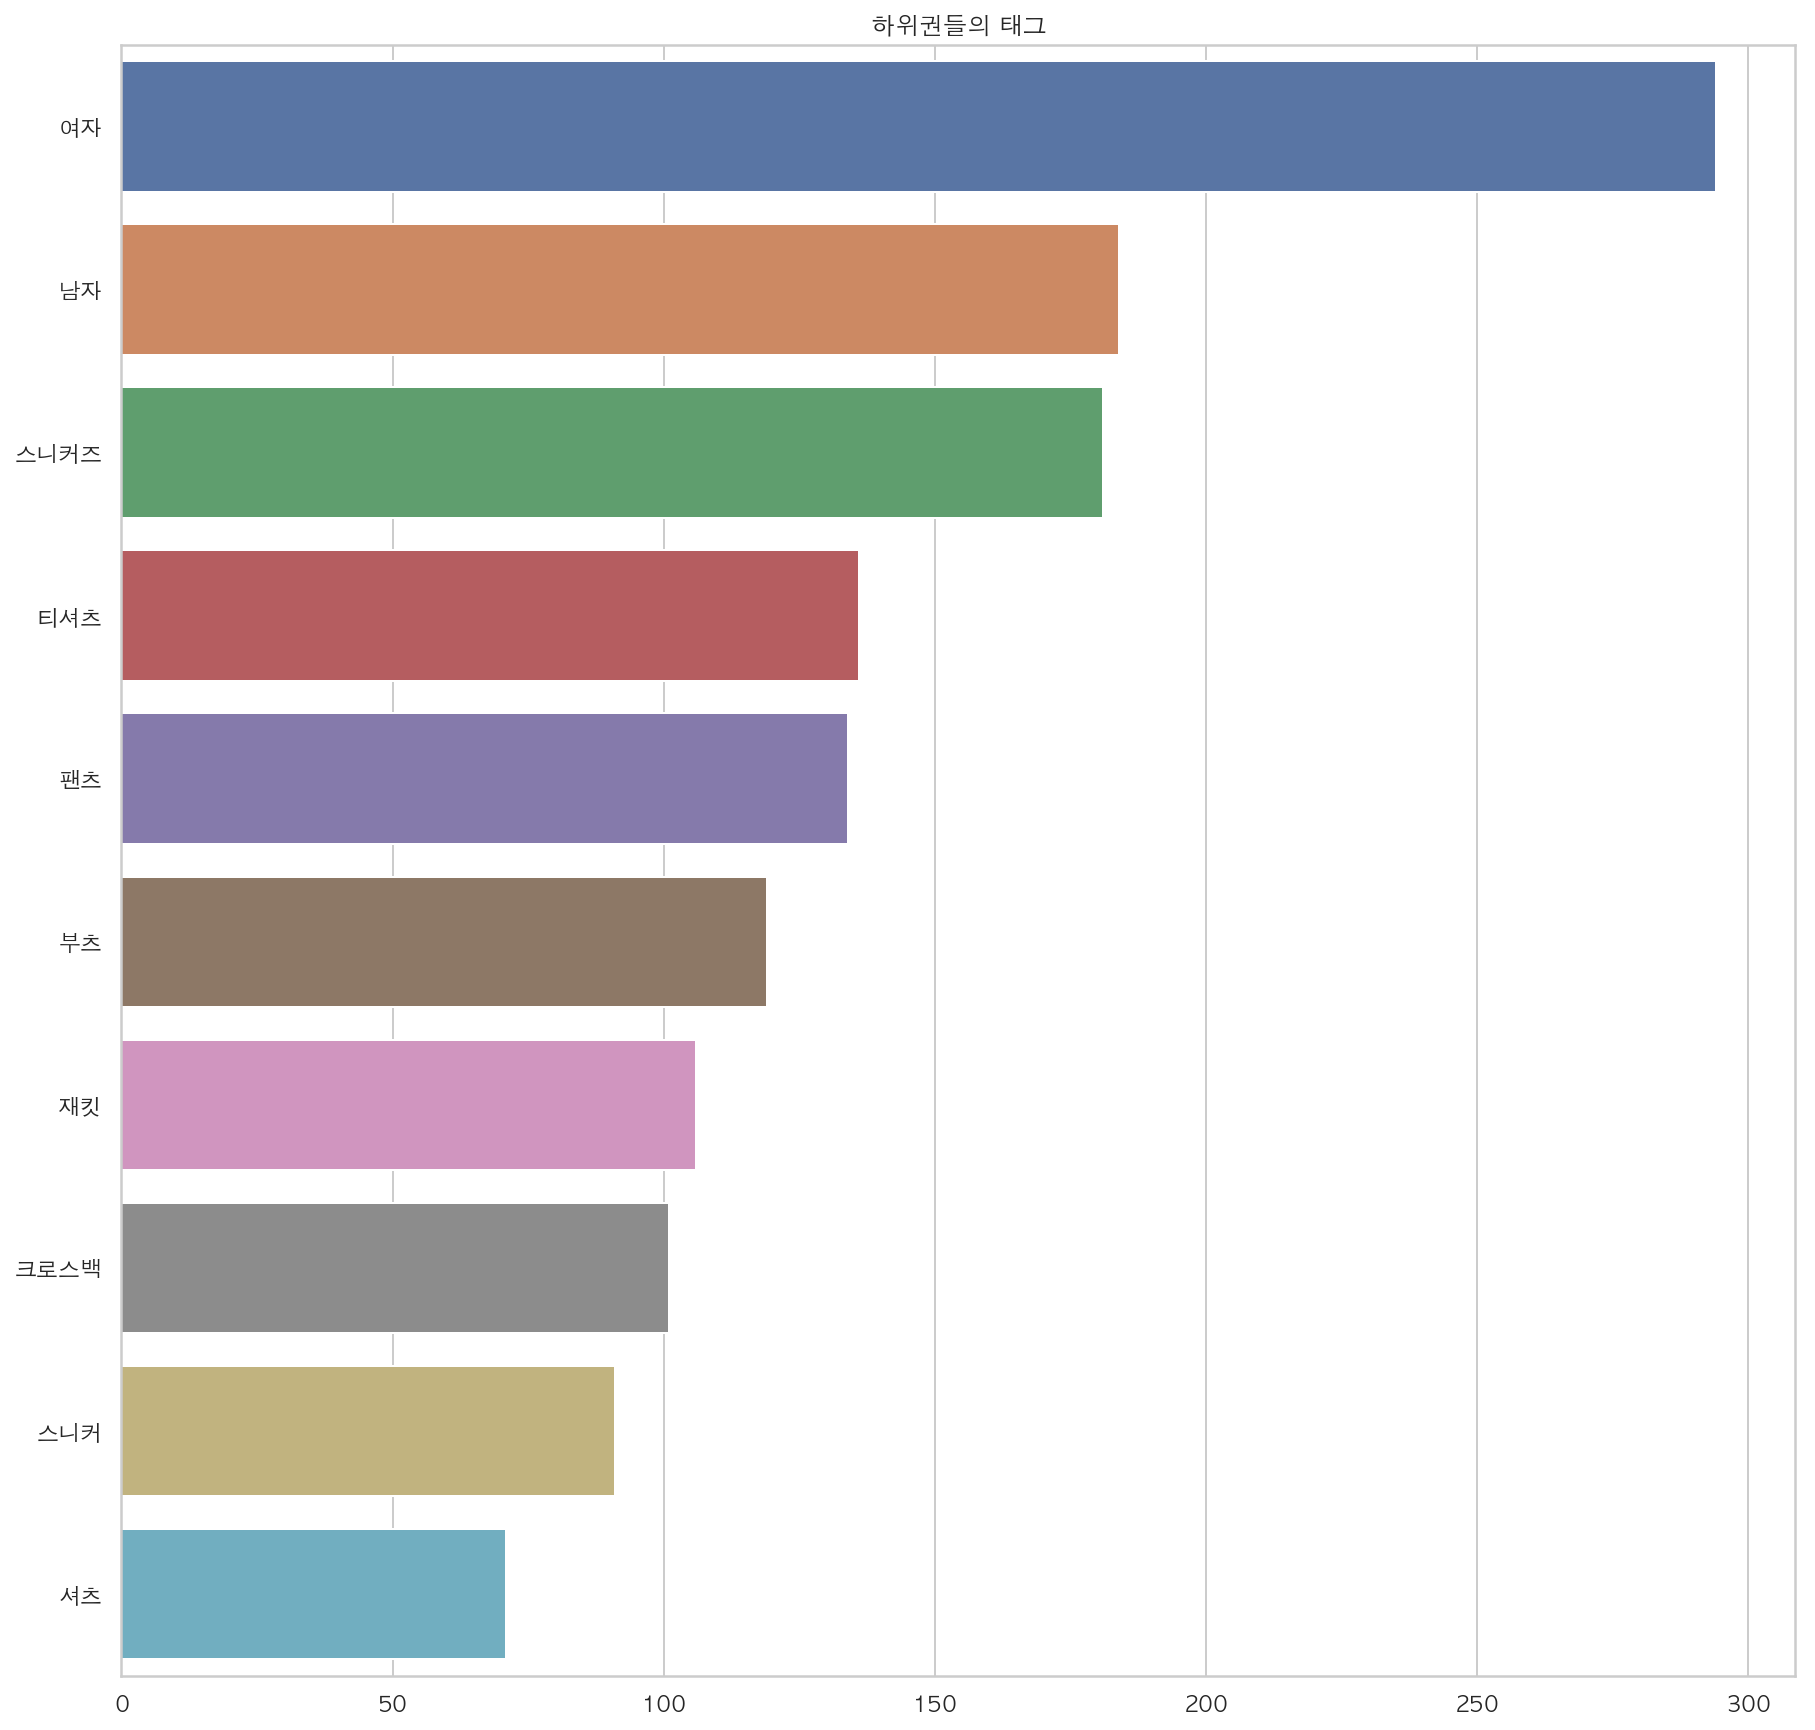

In [128]:
# tags_top

tags_bottom_s = sorted(tags_bottom.items(), key=lambda x : x[1], reverse=True)
plt.figure(figsize=(15, 15))
sns.barplot([t[1] for t in tags_bottom_s[:10]], [t[0] for t in tags_bottom_s[:10]])
plt.title("하위권들의 태그")
plt.show()

In [3]:
import keras

Using TensorFlow backend.


In [8]:
datagen = keras.preprocessing.image.ImageDataGenerator(zoom_range=0.2, vertical_flip=True, horizontal_flip=True)

In [10]:
gen = datagen.flow_from_directory("../data/images/", color_mode="rgb", batch_size=32, class_mode="categorical")

Found 7005 images belonging to 600 classes.


In [13]:
data = next(gen)

In [31]:
data[1].shape

dat

(32, 600)

In [32]:
epsilon = 1e-1
y1 = (1 - epsilon) * data[1] + (epsilon/data[1].shape[-1])

In [36]:
y1[0]

array([1.6666666e-04, 1.6666666e-04, 1.6666666e-04, 1.6666666e-04,
       1.6666666e-04, 1.6666666e-04, 1.6666666e-04, 1.6666666e-04,
       1.6666666e-04, 1.6666666e-04, 1.6666666e-04, 1.6666666e-04,
       1.6666666e-04, 1.6666666e-04, 1.6666666e-04, 1.6666666e-04,
       1.6666666e-04, 1.6666666e-04, 1.6666666e-04, 1.6666666e-04,
       1.6666666e-04, 1.6666666e-04, 1.6666666e-04, 1.6666666e-04,
       1.6666666e-04, 1.6666666e-04, 1.6666666e-04, 1.6666666e-04,
       1.6666666e-04, 1.6666666e-04, 1.6666666e-04, 1.6666666e-04,
       1.6666666e-04, 1.6666666e-04, 1.6666666e-04, 1.6666666e-04,
       1.6666666e-04, 1.6666666e-04, 1.6666666e-04, 1.6666666e-04,
       1.6666666e-04, 1.6666666e-04, 1.6666666e-04, 1.6666666e-04,
       1.6666666e-04, 1.6666666e-04, 1.6666666e-04, 1.6666666e-04,
       1.6666666e-04, 1.6666666e-04, 1.6666666e-04, 1.6666666e-04,
       1.6666666e-04, 1.6666666e-04, 1.6666666e-04, 1.6666666e-04,
       1.6666666e-04, 1.6666666e-04, 1.6666666e-04, 1.6666666e

In [ ]:
def gen_multiOutput(gen):
    while True:
        src = next(gen)
        x = data[0]
        y = data[1]
        
        yield []